In [ ]:
# Importando os pacotes necessários
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [ ]:
# Comandos auxiliares
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', 10)
pd.options.mode.chained_assignment = None  # default='warn'

def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes(
            "style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Transformação de Dados
---

Na <ins>**Transformação de dados**</ins>, o principal objetivo é exatamente **transformar** esses dados de diferentes formatos em um formato suportado pelo processo de pesquisa, e.g., modelos e algoritmos. 

---
## Dados desbalanceados

Outra técnica de <ins>**Transformação de dados**</ins> é o **Balanceamento de dados**.  

Especificamente, nós podemos dizer que os dados estão desbalanceados quando existe uma **desproporção** de observações de cada classe do nosso modelo. Os impactos do desbalanceamento são implícitos, ou seja, não geram um erro imediato ao construir e executar um modelo. 

⚠️ Porém, os resultados podem ser **ilusórios**. 

Se o sinal da classe *majoritária* for **bem maior** do que o sinal da classe *minoritária*, o classificador pode gerar uma alta precisão geral, uma vez que o modelo provavelmente irá prever a maioria das amostras pertencentes à classe majoritária. O que não quer dizer que o modelo teve um bom desempenho no geral. 

Por exemplo, em um problema de duas classes com uma distribuição de classe de `90:10`, o desempenho ao classificar as classes *majoritárias* será **nove** vezes maior do que o desempenho em exemplos de classes *minoritárias*.

> **Achou confuso?** Vamos para um exemplo então! 😉

### EXEMPLO

Para exemplificar, suponha que você tenha um modelo de classificação onde você precisa prever se uma música será uma colaboração ou não, com base em suas características acústicas. 

Resumindo, você teria um modelo de classificação binária com duas classes: 

* `Collaboration`
* `Solo`

Para começar, então, vamos selecionar apenas as colunas referentes aos nossos preditores (i.e., as características acústicas das músicas) e a nossa variável *target*, i.e., `song_type`:

In [ ]:
cols = [
    'duration_ms', 'key', 'mode', 'time_signature', 'acousticness',
    'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'valence', 'tempo', 'song_type'
]

# Selecionando algumas colunas da tabela Tracks
data = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv', encoding='utf-8', usecols=cols)
data.head(3)

⚠️ Note que a variável *target* `song_type` está em formato não-numérico. Como vimos anteriormente, nós **precisaríamos** transformá-la em uma variável numérica caso esta variável fosse usada em algum algoritmo de Aprendizado de Máquina. 

No entanto, neste caso, tal variável corresponde ao que queremos prever (i.e., variável *target*). Portanto, não precisamos aplicar nenhum tratamento aqui.

Podemos, então, seguir para a verificação do balanceamento das classes (`Solo` e `Collaboration`). 
Para isso, usamos a função `value_counts()` que computa os valores únicos de cada categoria:

In [ ]:
c = data['song_type'].value_counts() # quantidade de cada classe
p = data['song_type'].value_counts(normalize=True) # porcentagem de cada classe
pd.concat([c,round(p*100)], axis=1, keys=['counts', '%'])

Podemos observar que cerca de 41% das observações (i.e., 532 músicas) são colaborações. 

Portanto, se tivéssemos que prever sempre músicas `Solo` obteríamos uma precisão de 59%.

A seguir, iremos testar esse cenário criando um modelo linear de regressão logística, usando o módulo `sklearn.linear_model` e a classe `LogisticRegression`. Para isso, nós seguimos os seguintes passos:

1. Separamos o conjunto de predidores (X) da nossa variável *target* (y);

In [ ]:
# primeiro passo
y = data.song_type # variável target
X = data.drop('song_type', axis=1) # conjunto de preditores

2. Treinamos o modelo de regressão logística com os dois conjuntos X e y;

In [ ]:
# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

3. Realizamos a predição utilizando o mesmo conjunto de preditores X; e, por fim, 
4. Imprimimos os resultados.

In [ ]:
# terceiro passo
pred_y_0 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_0, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_0)) # classes previstas pelo modelo

Como podemos ver pelo resultado, nosso modelo apresentou uma precisão geral de 59%; ou seja, como consequência dos dados desbalanceados, o modelo prevê apenas uma classe. 

Em outras palavras, ele **ignora** a classe minoritária (i.e., `Collaborations`) em favor da classe majoritária (i.e., `Solo`). 

> **Então, como solucionar este problema?** 🤔

Uma técnica amplamente adotada para lidar com conjuntos de dados desbalanceados é a **Reamostragem**. 

#### REAMOSTRAGEM DE CLASSES

Esta técnica pode ser dividida em duas abordagens diferentes: 

* **Downsampling:** consiste em **remover** amostras da classe *majoritária* 
* **Oversampling:** consiste em **adicionar** mais exemplos da classe *minoritária*  

<br>
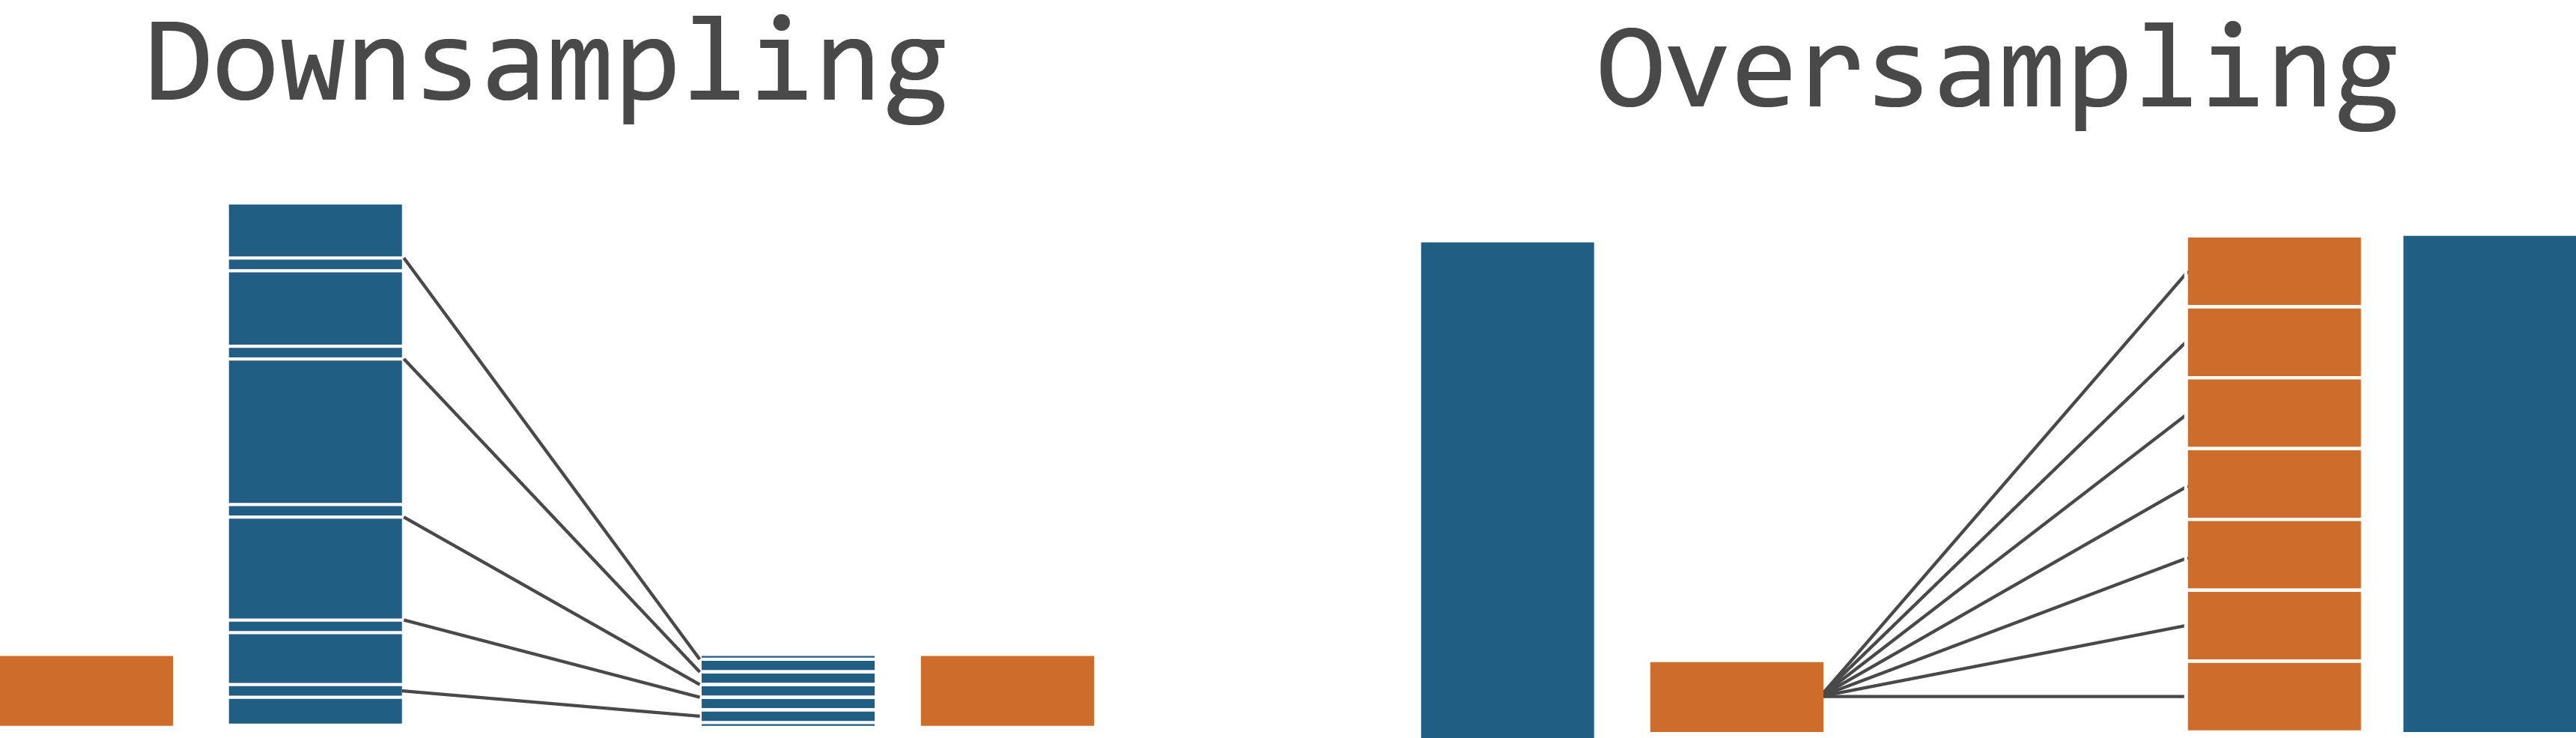

A seguir, vamos aplicar as duas técnicas no nosso exemplo de predição de colaborações.

---

**1. Downsampling** 

Começamos aplicando a técnica de *Downsampling*, que remove aleatoriamente observações da classe majoritária para evitar que seu sinal domine o algoritmo de aprendizagem. Para isso, seguimos alguns passos:

1. Separamos as observações de cada classe em diferentes *DataFrames*;

In [ ]:
# primeiro passo
df_majority = data[data.song_type == 'Solo'] # classe majoritária
df_minority = data[data.song_type == 'Collaboration'] # classe minoritária

2. Realizamos uma amostragem da classe majoritária sem substituição para corresponder ao número total da classe minoritária;

In [ ]:
# segundo passo
df_majority_downsampled = resample(
    df_majority, replace=False,  # amostra sem substituição
    n_samples=len(df_minority),  # para corresponder à classe minoritária
    random_state=123)  # garantindo reprodutibilidade

3. Concatenamos o *DataFrame* da classe minoritária com o *DataFrame* resultante;

In [ ]:
# terceiro passo
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.song_type.value_counts()

In [ ]:
print(df_downsampled.shape[0], data.shape[0]) # comparando o tamanho dos DataFrames

⚠️ Note que, apesar do novo *DataFrame* ter menos observações do que o original, a proporção das duas classes está **balanceada**. 

Agora, podemos treinar novamente o modelo de regressão logística! 

In [ ]:
# primeiro passo
y = df_downsampled.song_type # variável target
X = df_downsampled.drop('song_type', axis=1) # conjunto de preditores

# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

# terceiro passo
pred_y_1 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_1, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_1)) # classes previstas pelo modelo

Obeserve que, após o balanceamento, o modelo consegue prever as duas classes e, apesar de apresentar uma menor precisão (49%), o modelo apresenta uma métrica de avaliação mais significativa. 

**2. Oversampling** 

Vamos, agora, aplicar a técnica de *Oversampling*, que replica aleatoriamente observações da classe minoritária. Para isso, seguimos alguns passos:

1. Separamos as observações de cada classe em diferentes *DataFrames*;

In [ ]:
# primeiro passo
df_majority = data[data.song_type == 'Solo'] # classe majoritária
df_minority = data[data.song_type == 'Collaboration'] # classe minoritária

2. Realizamos a replicação da classe minoritária para corresponder ao número total da classe majoritária;

In [ ]:
# segundo passo
df_minority_oversampled = resample(
    df_minority, # replicação aleatória
    n_samples=len(df_majority),  # para corresponder à classe majoritária
    random_state=123)  # garantindo reprodutibilidade

3. Concatenamos o *DataFrame* da classe majoritária com o *DataFrame* resultante.

In [ ]:
# terceiro passo
df_oversampled = pd.concat([df_minority_oversampled, df_majority])
df_oversampled.song_type.value_counts()

In [ ]:
print(df_oversampled.shape[0], data.shape[0]) # comparando o tamanho dos DataFrames

Observe que, desta vez, o novo *DataFrame* possui mais observações do que o original após a replicação das classes minoritárias, como esperado.

Agora, podemos treinar novamente o modelo de regressão logística!

In [ ]:
# primeiro passo
y = df_oversampled.song_type # variável target
X = df_oversampled.drop('song_type', axis=1) # conjunto de preditores

# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

# terceiro passo
pred_y_1 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_1, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_1)) # classes previstas pelo modelo

Mais uma vez, após o balanceamento, o modelo conseguiu prever as duas classes apresentando uma métrica de precisão mais significativa. 

## Conclusão

Este notebook apresentou uma técnica avançada de transformação de dados.

🔎 **Se interessou?** 

* Dê uma olhada na documentação da biblioteca *sklearn* para informações extras sobre transformação de dados:
[Dataset transformations](https://scikit-learn.org/stable/data_transforms.html)

---

O próximo notebook ([4.2.Reducao.ipynb](4.2.Reducao.ipynb)) apresenta como aplicar técnicas de redução de dados para auxiliar a análise de dados com alta dimensionalidade.